<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Timeseries/Household_power_consumption_multivariate_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Household Power Consumption Dataset**
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

global_active_power: The total active power consumed by the household (kilowatts).

global_reactive_power: The total reactive power consumed by the household (kilowatts).

voltage: Average voltage (volts).

global_intensity: Average current intensity (amps).

sub_metering_1: Active energy for kitchen (watt-hours of active energy).

sub_metering_2: Active energy for laundry (watt-hours of active energy).

sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current.

In general terms, the active energy is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

We can see that the dataset provides the active power as well as some division of the active power by main circuit in the house, specifically the kitchen, laundry, and climate control. These are not all the circuits in the household.

The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

# Imports

In [8]:
import urllib
import os
import zipfile
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import zipfile


# Copy data

## Approach 1: Upload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
!mkdir data
!cp '/content/drive/MyDrive/Data Science & Machine Learning/Tensorflow Certification/Repository/Tensorflow_projects/Data/Household Power Consumption/cleaned/household_power_consumption.csv' './data/'

mkdir: cannot create directory ‘data’: File exists


In [75]:
datafile = "./data/household_power_consumption.csv"

In [76]:
df = pd.read_csv(datafile, sep=',', infer_datetime_format=True, index_col='datetime', parse_dates=['datetime'])

<ipython-input-76-b63c19fe3de2>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(datafile, sep=',', infer_datetime_format=True, index_col='datetime', parse_dates=['datetime'])


## Approach 2: UCI-Copy Data

 Download Data Set: UCI Machine Learning repository as a single 20 megabyte .zip file:

[household_power_consumption.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip)


In [12]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2024-04-13 23:22:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [    <=>             ]  19.68M  23.9MB/s    in 0.8s    

2024-04-13 23:22:37 (23.9 MB/s) - ‘household_power_consumption.zip’ saved [20640916]



In [13]:
zip_ref = './household_power_consumption.zip'
datafile = "./data/household_power_consumption.txt"

file = zipfile.ZipFile(zip_ref, 'r')
file.extractall('./data')
file.close()

In [14]:
df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)

<ipython-input-14-6f90a0c86db3>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)
<ipython-input-14-6f90a0c86db3>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)


# Helper Function

In [77]:
# Auxiliary plotting function
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [78]:
# Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):

	scores = []

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):

		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])

		# calculate rmse
		rmse = sqrt(mse)

		# store the rmse in list
		scores.append(rmse)

	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):

			s = s + (actual[row, col] - predicted[row, col])**2
	overall_score = sqrt(s / (actual.shape[0] * actual.shape[1]))

	return overall_score, scores

In [79]:
from numpy import nan

# fill missing values with a value at the same time one day ago
def fill_missing(values):
  one_day = 60 * 24 #granulatiy of data is minutes
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row, col]):
        print("replacing missing value of ",values[row, col],"at position [",row, col,"] with :",values[row - one_day, col])
        values[row, col] = values[row - one_day, col] #if given day has 'nan' , then replace the value with previous day's reading

# Data Insights

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86400 entries, 2006-12-16 17:24:00 to 2007-02-14 17:23:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    86400 non-null  float64
 1   Global_reactive_power  86400 non-null  float64
 2   Voltage                86400 non-null  float64
 3   Global_intensity       86400 non-null  float64
 4   Sub_metering_1         86400 non-null  float64
 5   Sub_metering_2         86400 non-null  float64
 6   Sub_metering_3         86400 non-null  float64
dtypes: float64(7)
memory usage: 5.3 MB


In [81]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Data Transformation

## Missing data

In [82]:
from numpy import nan

# # mark all missing values
df.replace('?', nan, inplace=True)

# make dataset numeric
df = df.astype('float32')

Check if any values are missing

In [83]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill_missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [84]:
from math import isnan

# fill missing
fill_missing(df.values)

Now we can create a new column that contains the remainder of the sub-metering, using the calculation from the previous section.The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

In [21]:
# add a column for for the remainder of sub metering
values = df.values
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6]) #this operation can only be done using series

## Convert data to daily grain

As we notice here , data here is in hourly grain. We should transform the data to daily grain in order to be able to make daily forecasts.

In [85]:
#resample data to daily
daily_groups = df.resample('D') #D=daily
print(daily_groups)

DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, origin=start_day]


In [86]:
dailyDF = daily_groups.sum()

# summarize
print(dailyDF.shape)
display(dailyDF.head())

(61, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


# Training - Validation Split

We will use the first three years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday.

This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted. It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.

We will split the data into standard weeks, working backwards from the test dataset.

In [87]:
print(dailyDF)

            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   
...                         ...                    ...           ...   
2007-02-10          2829.327881             192.973999  345653.03125   
2007-02-11          3571.228027             204.313995  344888.84375   
2007-02-12          1877.609985             136.703995  345741.84375   
2007-02-13          1414.546021             134.677994  347280.28125   
2007-02-14          1741.764038             143.328003  251928.81250   

            Global_intensity  Sub_metering_1  Sub_metering_2  S

As we can see, the last record in data is of 2010-11-26. Assuming the week starts as Sunday. So, let's try to pull earliest data of 2010 year in Sunday which is 2010-01-03. This is our testing set.

All remaining data i.e, 2006-12-16 till 2010-01-02 is our training data.

In [101]:
# Number of features in the dataset. We use all features as predictors to predict all features of future time steps.
num_features = len(dailyDF.columns)

In [88]:
series_val = dailyDF["2007-01-07":"2007-02-14"]
series_train = dailyDF["2006-12-16":"2010-01-06"]

# series_val = dailyDF["2010-01-03":"2010-11-26"]
# series_train = dailyDF["2006-12-16":"2010-01-02"]

In [90]:
SPLIT_TIME = np.array(series_val).shape[0]

# Data Normalization

In [91]:
data = np.array(series_train)
train_mean = data.mean()
train_std = data.std()

In [92]:
series_val = (series_val - train_mean)/train_std
series_train = (series_train - train_mean)/train_std

# Global Parameters

In [93]:
# Hyper-Parameters
BATCH_SIZE = 32 # Batch size
N_PAST = 7 # Number of past time steps based on which future observations should be predicted
N_FUTURE = 7 # Number of future time steps which are to be predicted.
SHIFT = 1 # By how many positions the window slides to create a new window of observations.

# Batching of dataset

In [94]:

# This is multi step prediction.
# window size = n_past + n_future
# n_past --> no. of previous observations used to make forecast
# n_future --> horizon for which we make forecast

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))

    # Create tuples with features and labels
    ds = ds.map(lambda w: (w[:n_past], w[n_past:])) #(window[:-1], window[-1])

    # Create batches of windows
    dataset = ds.batch(batch_size).prefetch(1)

    return dataset

In [95]:
# Windowed train and validation datasets.
train_set = windowed_dataset(series_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
valid_set = windowed_dataset(series_val, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

In [98]:
# Print the data shape
for window in train_set.take(1):
    print(f'Shape of feature: {window[0].shape}')
    print(f'Shape of label: {window[1].shape}')

for window in valid_set.take(1):
    print(f'Shape of feature: {window[0].shape}')
    print(f'Shape of label: {window[1].shape}')

Shape of feature: (32, 7, 7)
Shape of label: (32, 7, 7)
Shape of feature: (26, 7, 7)
Shape of label: (26, 7, 7)


# Build Model

In [48]:
# Code to define your model.
inputs = tf.keras.layers.Input(shape=[N_PAST, num_features])
# x = normalizer(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
#tf.keras.layers.Dropout(0.2),
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
#tf.keras.layers.Dropout(0.2),
x = tf.keras.layers.Dense(num_features* N_FUTURE)(x)
outputs = tf.keras.layers.Reshape([N_FUTURE, num_features])(x)

model = tf.keras.Model(inputs,outputs)

# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 8)]            0         
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            140288    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 128)            164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 56)                3640      
                                                             

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [99]:
#Get initial weights
init_weights = model.get_weights()

In [100]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch/20))

# Initialize the optimizer
optimizer=tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 7, 8), found shape=(None, None, 7)


(1e-05, 1000.0, 0.0, 1.0)

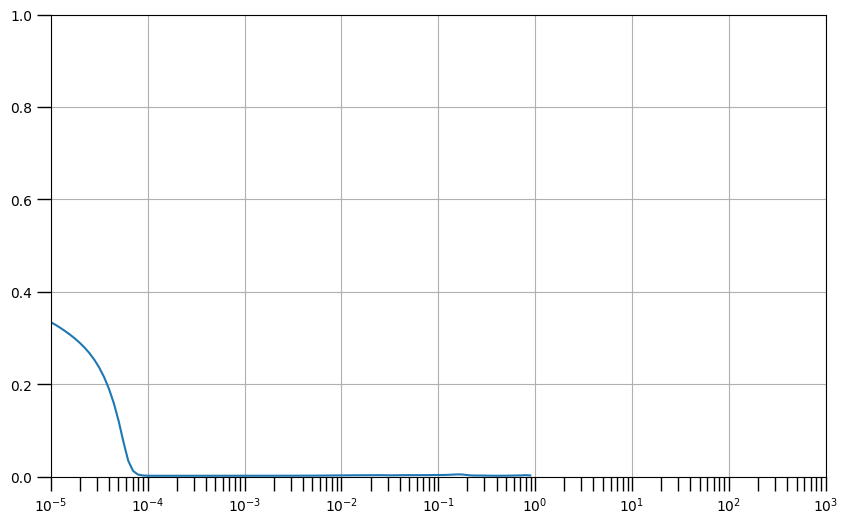

In [53]:
# # Define the learning rate array
lrs = 1e-5 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-5, 1e3, 0, 1])

## Train the Model Completely(for longer epoch)

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [137]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [55]:
# Initialize learning rate
lr = 6e-5

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=lr)


# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae','mse'])

#callback
RLP = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    patience=3,
    verbose=2,
    mode="auto"
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=15,
    verbose=2,
    mode="auto",
    start_from_epoch=10
)

# Train the model
history = model.fit(train_set, epochs=500, validation_data=valid_set, verbose = 2, callbacks=[ES])

Epoch 1/500
35/35 - 16s - loss: 0.0024 - mae: 0.0269 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0369 - val_mse: 0.0416 - 16s/epoch - 467ms/step
Epoch 2/500
35/35 - 3s - loss: 0.0024 - mae: 0.0269 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0369 - val_mse: 0.0416 - 3s/epoch - 96ms/step
Epoch 3/500
35/35 - 3s - loss: 0.0024 - mae: 0.0268 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0369 - val_mse: 0.0416 - 3s/epoch - 80ms/step
Epoch 4/500
35/35 - 2s - loss: 0.0024 - mae: 0.0268 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0369 - val_mse: 0.0416 - 2s/epoch - 53ms/step
Epoch 5/500
35/35 - 2s - loss: 0.0024 - mae: 0.0268 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0368 - val_mse: 0.0416 - 2s/epoch - 53ms/step
Epoch 6/500
35/35 - 2s - loss: 0.0024 - mae: 0.0268 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0368 - val_mse: 0.0416 - 2s/epoch - 53ms/step
Epoch 7/500
35/35 - 3s - loss: 0.0024 - mae: 0.0268 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0368 - val_mse: 0.0416 - 3s/epoch -

## Visualize the model

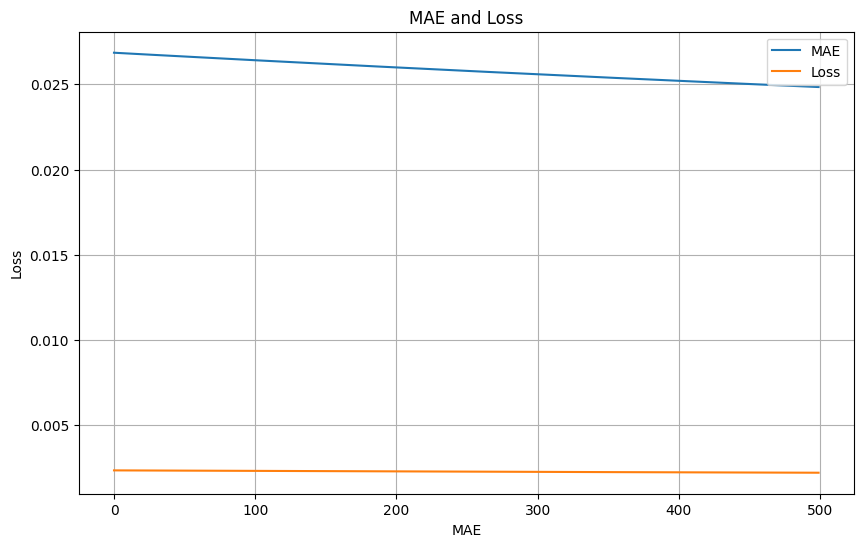

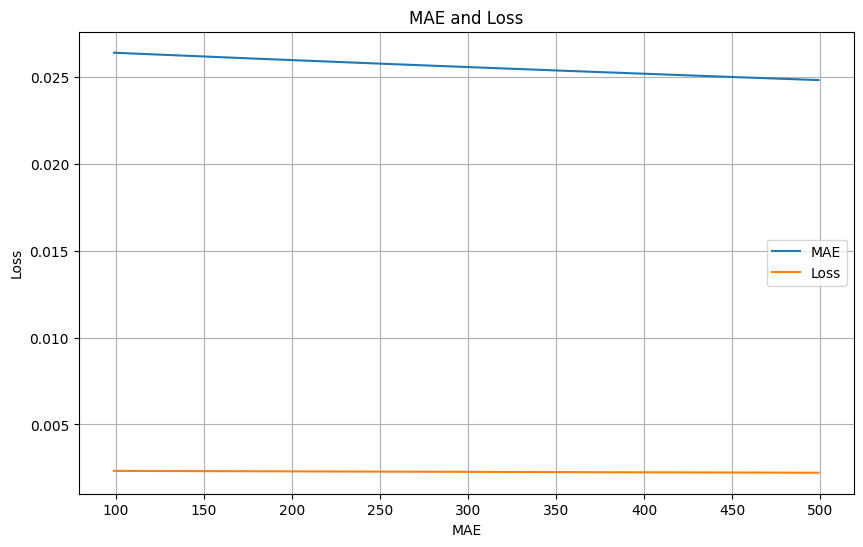

In [56]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))


# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# print(int(epochs[-1]*0.2))
# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Forcasting

In [57]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    ds = ds.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(ds)

    return forecast

In [58]:
# First Prediction
forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
print('Output shape:', forecast[0].shape)
print('First prediction: \n', forecast[0])

35/35 [==============================] - 3s 18ms/step
Output shape: (7, 8)
First prediction: 
 [[-0.4071157  -0.41958058  2.7386804  -0.361528   -0.40809157 -0.40695283
  -0.32899168 -0.29696998]
 [-0.40695167 -0.41694748  2.727849   -0.35836852 -0.40724322 -0.40563685
  -0.32585555 -0.29588565]
 [-0.4064793  -0.41913515  2.7173567  -0.35564297 -0.40669444 -0.40466517
  -0.32466602 -0.28581664]
 [-0.40069476 -0.41557178  2.7128313  -0.35261175 -0.40167752 -0.4080875
  -0.32590657 -0.2860824 ]
 [-0.40301982 -0.41856098  2.702012   -0.34879392 -0.39832085 -0.40388474
  -0.31479824 -0.28345108]
 [-0.4050302  -0.41787276  2.6856883  -0.35017762 -0.39785388 -0.40533328
  -0.32643718 -0.28241423]
 [-0.40246445 -0.4181832   2.6827369  -0.3503397  -0.39627185 -0.40928194
  -0.33043224 -0.27397272]]


In [73]:
# PASS THE NORMALIZED data IN THE FOLLOWING CODE
# forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
forecast = forecast[SPLIT_TIME - N_PAST:-1]
# series_val = series_val[:forecast.shape[0]]

# print(forecast.shape, series_val.shape)

# # Compute the MAE
# MAE = tf.keras.metrics.MeanAbsoluteError()
# MAE.update_state(series_val[:,:], forecast[:,:]) #Accumulate statistics for the metric.
# MAE = MAE.result().numpy() #Compute the current metric value.
# print('Validation MAE:', round(MAE, 4))

# Plot the results
# plot_series(np.squeeze(time_valid)[:series_val.shape[0]], (series_val, forecast))